In [77]:
import os
import re
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

from IPython.display import display, HTML
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Local Utils File
from utils.eda import *
from utils.road_tax import *
from utils.kanhon_utils import *
from utils.melissa_imputers import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression
from utils.regression_evaluation import *

## Feature Processing

### Test Data preview

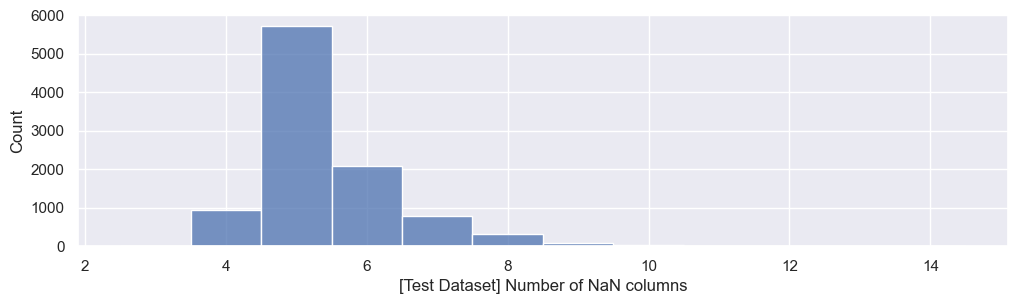

In [91]:
test_df = pd.read_csv(r"./dataset/test.csv")
test_df['model'] = test_df['model'].apply(lambda x:x.replace('(', ''))
test_df['reg_date_dt'] = test_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
test_df['reg_date_year'] = test_df['reg_date_dt'].apply(lambda x:x.year)
test_df['reg_date_month'] = test_df['reg_date_dt'].apply(lambda x:x.month)

plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = test_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Test Dataset] Number of NaN columns')
plt.show()

In [97]:
test_df.isna().sum()

listing_id               0
title                    0
make                   541
model                    0
description            268
manufactured             3
original_reg_date     9903
reg_date                 0
type_of_vehicle          0
category                 0
transmission             0
curb_weight            110
power                 1086
fuel_type             7650
engine_cap             235
no_of_owners             8
depreciation           201
coe                      0
road_tax              1082
dereg_value             83
mileage               2166
omv                     29
arf                     65
opc_scheme            9953
lifespan              9026
eco_category             0
features               323
accessories           1566
indicative_price     10000
reg_date_dt              0
reg_date_year            0
reg_date_month           0
dtype: int64

In [108]:
test_df.type_of_vehicle.unique()

array(['suv', 'mid-sized sedan', 'sports car', 'hatchback',
       'luxury sedan', 'mpv', 'van', 'truck', 'stationwagon',
       'bus/mini bus', 'others'], dtype=object)

In [104]:
set(orig_df.type_of_vehicle.unique()) == set(test_df.type_of_vehicle.unique())

True

### Read and clean dataset

In [3]:
orig_df = pd.read_csv(r"./dataset/train.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)

# Adding additional feature for imputation later
# train_df["model_make"] = train_df.model + "_" + train_df.make

General overview of Nan Columns

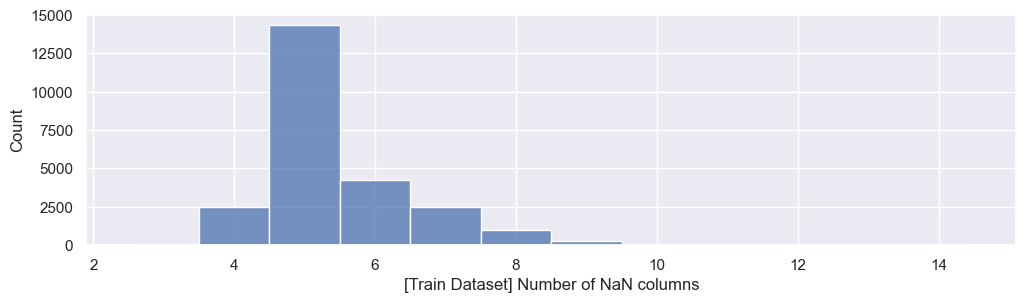

In [7]:
plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = train_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Train Dataset] Number of NaN columns')
plt.show()

In [10]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   listing_id         25000 non-null  int64         
 1   title              25000 non-null  object        
 2   make               23684 non-null  object        
 3   model              25000 non-null  object        
 4   description        24320 non-null  object        
 5   manufactured       24993 non-null  float64       
 6   original_reg_date  255 non-null    object        
 7   reg_date           25000 non-null  object        
 8   type_of_vehicle    25000 non-null  object        
 9   category           25000 non-null  object        
 10  transmission       25000 non-null  object        
 11  curb_weight        24693 non-null  float64       
 12  power              22360 non-null  float64       
 13  fuel_type          5879 non-null   object        
 14  engine

In [33]:
## Split into train val split
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

### Fill missing 'make' info from title

In [34]:
make_df = pd.read_csv(r"./dataset/make.csv")
make_ls = [make.lower() for make in make_df['Make List'].unique()]

In [35]:
make_model_imputer = MakeModelImputer(make_ls)

train_df = make_model_imputer.transform(train_df)
val_df = make_model_imputer.transform(val_df) 
test_df = make_model_imputer.transform(test_df) 

In [36]:
# Generating model make imputer
train_df["model_make"] = train_df.model + "_" + train_df.make
val_df["model_make"] = val_df.model + "_" + val_df.make
test_df["model_make"] = test_df.model + "_" + test_df.make

### type_of_vehicle

In [12]:
# For each model and make check the type of vehicles count
unique_list = display_feature_dist_by_ref_col(df=train_df,feature="type_of_vehicle",ref="model_make")
make_models_with_diff_bodies = list()
for key, value in unique_list.items():
    if len(value) >= 2:
        make_models_with_diff_bodies.append(key)

Number of model_make unable to be inputted 0


In [71]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="type_of_vehicle", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [22]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.scatter(train_df, x="omv", y='price', color="type_of_vehicle",trendline="ols")

# Show the figure
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [37]:
## Processing 
train_df , vehicle_type_encoder = vehicle_type_fit_transform(train_df, "type_of_vehicle")
val_df = vehicle_type_fit(val_df, vehicle_type_encoder)
test_df = vehicle_type_fit(test_df, vehicle_type_encoder)

### curb_weight

In [15]:
# Superceeded # display(HTML(train_df.head(50).to_html()))
def fill_column_b_with_mean(df, column_a, column_b):
    # Calculate the mean of column B grouped by column A
    values = df.groupby(column_a)[column_b].agg(["mean"]).rename(columns={"mean": column_b})[column_b]
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # If column B is NaN, fill it with the mean value of column B for the corresponding value in column A
        if pd.isna(row[column_b]):
            df.at[index, column_b] = values[row[column_a]]
    return df

In [38]:
curb_weight_impute = ModelMakeImputer(column_a="model_make", column_b="curb_weight")

train_df = curb_weight_impute.fit_transform(train_df) # 82 rows missing
val_df = curb_weight_impute.transform(val_df) # 20 rows missing
test_df = curb_weight_impute.transform(test_df) # 40 rows missing

In [39]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['curb_weight'] = imputer.fit_transform(train_df[['curb_weight']])
val_df['curb_weight'] = imputer.transform(val_df[['curb_weight']])
test_df['curb_weight'] = imputer.transform(test_df[['curb_weight']])

### power 

In [40]:
power_impute = ModelMakeImputer(column_a="model_make", column_b="power")

train_df = power_impute.fit_transform(train_df) # 1537 rows missing
val_df = power_impute.transform(val_df) # 379 rows missing
test_df = power_impute.transform(test_df) # 789 rows missing

In [41]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['power'] = imputer.fit_transform(train_df[['power']])
val_df['power'] = imputer.transform(val_df[['power']])
test_df['power'] = imputer.transform(test_df[['power']])

### engine_cap 

In [42]:
engine_impute = ModelMakeImputer(column_a="model_make", column_b="engine_cap")

train_df = engine_impute.fit_transform(train_df) # 384 rows missing
val_df = engine_impute.transform(val_df) # 97 rows missing
test_df = engine_impute.transform(test_df) # 186 rows missing

In [43]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['engine_cap'] = imputer.fit_transform(train_df[['engine_cap']])
val_df['engine_cap'] = imputer.transform(val_df[['engine_cap']])
test_df['engine_cap'] = imputer.transform(test_df[['engine_cap']])

### no_of_owners

In [11]:
# display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# # Original Code Output
# rows = train_df[train_df["no_of_owners"].isna()].index

# for r in rows:
#     row = train_df.iloc[r]

#     #Impute number of owners based on reg_date
#     regDate = row["reg_date"]
#     months = calculate_date_diff(regDate)

#     # We estimate the number of owners based on every 3 years or 36 months
#     estimated_owners = math.ceil(months / 36)
#     train_df.loc[r, "no_of_owners"] = estimated_owners

# display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

In [20]:
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# Function form
train_df = impute_owner_number(train_df)

display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 0'

' After imputation : 0'

In [6]:
train_df.reg_date.isna().sum()

0

In [44]:
## New method
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')

owner_impute = OwnerImputer()

train_df = owner_impute.fit_transform(df=train_df)
val_df = owner_impute.transform(val_df)
test_df = owner_impute.transform(test_df)
display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 11'

19989
[Number of months per owner]  ->  [mean = 48.48792002267915, median = 41.0, mode = 28.0]


' After imputation : 0'

In [26]:
test_df.no_of_owners.isna().sum()

0

### Manufactured

In [21]:
# Manufactured

train_df['effective_reg_date'] = train_df['original_reg_date'].fillna(train_df['reg_date'])
train_df = train_df.drop(columns=['original_reg_date'])

train_df['effective_reg_date'] = pd.to_datetime(train_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
train_df['manufactured'] = train_df['manufactured'].fillna(train_df['effective_reg_date'].dt.year)

### depreciation 

In [45]:
dep_imputer = DepreciationImputer()

train_df = dep_imputer.fit_transform(X=train_df)
val_df = dep_imputer.transform(X=val_df)
test_df = dep_imputer.transform(X=test_df)

### Transmission

In [21]:
# Transmission

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=['transmission'], prefix='transmission')
train_df.drop('transmission_manual', axis=1, inplace=True)

unique_transmissions = train_df['transmission_auto'].unique()
transmission_counts = train_df['transmission_auto'].value_counts()
print(unique_transmissions, transmission_counts)

[ True False] transmission_auto
True     18660
False     1340
Name: count, dtype: int64


### dereg_value

### mileage   

In [24]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
# Original Code Output
rows = train_df[train_df["mileage"].isna()].index
for r in rows:
    row = train_df.iloc[r]
    #print(f"row: {row}")
    regDate = row["reg_date"]
    months = calculate_date_diff(regDate)

    #impute mileage based on reg_date 
    #we estimate that the average mileage of a car is 8000 miles per year
    estimated_mileage = months / 12 * 8000
    train_df.loc[r, "mileage"] = estimated_mileage

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 5304'

' After imputation : 0'

In [46]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
## New method

mileage_impute = mileageImputer()

train_df = mileage_impute.fit_transform(df=train_df)
val_df = mileage_impute.transform(val_df)
test_df = mileage_impute.transform(test_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 4248'

[Miles per month]  ->  [mean = 1008.1117259874483, median = 979.3646346929628, mode = 1000.0]


' After imputation : 0'

### omv 

In [47]:
csv_filename = r'./dataset/lta_omv_data.csv'

if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)

lta_data_imputer = LTADataImputer(df_lta_car_data)

train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing
test_df = lta_data_imputer.transform(test_df) 

imputer = SimpleImputer(strategy='median')
train_df['omv'] = imputer.fit_transform(train_df[['omv']])
val_df['omv'] = imputer.transform(val_df[['omv']])
test_df['omv'] = imputer.transform(test_df[['omv']])

In [27]:
# Superceeded code
def impute_using_lta_data(row):
    # print(row)
    if not np.isnan(row['omv']):
        return row['omv']
    else:
        make = row['make']
        model = row['model']
        year = row['reg_date_year']
        lookup_by_make_model_year = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model)) & (df_lta_car_data['year'] == year)]
        
        lookup_by_make_model = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model))]

        lookup_by_make = df_lta_car_data[(df_lta_car_data['make_clean'] == make)]
        
        if not lookup_by_make_model_year.empty:
            # print('lookup_by_make_model_year')
            return lookup_by_make_model_year['omv_clean'].mean()
        elif not lookup_by_make_model.empty:
            # print('lookup_by_make_model')
            return lookup_by_make_model['omv_clean'].mean()
        elif not lookup_by_make.empty:
            # print('lookup_by_make')
            return lookup_by_make['omv_clean'].mean()
        else: 
            return None

# train_df['omv_new'] = train_df['omv']
# train_df['omv_new'] = train_df.apply(impute_using_lta_data, axis=1)
# train_df['omv_new'] = train_df['omv_new'].fillna(train_df['omv_new'].mean())

# train_df.info()

### Lifespan

In [29]:
display(f' Before imputation : {train_df["lifespan"].isna().sum()}')

# Functional Form
impute_lifespan(train_df)

display(f' After imputation : {train_df["lifespan"].isna().sum()}')

' Before imputation : 22671'

len of lifespan na: 22671


' After imputation : 0'

### Fuel Type

In [30]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="fuel_type", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [31]:
get_fuel_type(train_df)

Original Imputation Nan 19121
After Imputation Nan 17956


,listing_id,title,make,model,description,manufactured,reg_date,type_of_vehicle,category,curb_weight,...,reg_date_month,model_make,extracted_make,curb_weight_impute,power_impute,engine_cap_impute,effective_reg_date,car_age,transmission_auto,omv_new
0,1292132,Land Rover Range Rover Velar 3.0A Si6 R-Dynami...,land rover,range,"1 owner, no repairs needed! it looks great, in...",2018.0,08-mar-2018,suv,parf car,1884.0,...,3,range_land rover,land rover,1884.0,280.0,2995.0,2018-03-08,6.0,True,88906.0
1,1294696,Mercedes-Benz C-Class C200 Sport Premium Sunroof,mercedes-benz,c200,rare beautiful white c200 sport premium sunroo...,2017.0,28-dec-2017,luxury sedan,"parf car, premium ad car",1465.0,...,12,c200_mercedes-benz,mercedes-benz,1465.0,135.0,1991.0,2017-12-28,7.0,True,40678.0
2,1311717,Honda Odyssey 2.4A (COE till 09/2027),honda,odyssey,comes with warranty. full service done.,2007.0,19-sep-2007,mpv,"coe car, premium ad car, low mileage car",1648.0,...,9,odyssey_honda,honda,1648.0,118.0,2354.0,2007-09-19,17.0,True,27994.0
3,1310068,Toyota Corolla Altis 1.6A (COE till 12/2028),toyota,altis,0,2008.0,15-dec-2008,mid-sized sedan,"coe car, premium ad car",1195.0,...,12,altis_toyota,toyota,1195.0,80.0,1598.0,2008-12-15,16.0,True,16084.0
4,1325280,Lexus GS300 (COE till 06/2026),lexus,gs,wear and tear done up. well maintained and reg...,2006.0,22-dec-2006,luxury sedan,"coe car, premium ad car",1660.0,...,12,gs_lexus,lexus,1660.0,183.0,2995.0,2006-12-22,18.0,True,50414.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1329201,Mercedes-Benz C-Class C180 (COE till 06/2031),mercedes-benz,c180,elegant looking and very well maintained by ow...,2011.0,14-jul-2011,luxury sedan,"coe car, premium ad car, low mileage car",1500.0,...,7,c180_mercedes-benz,mercedes-benz,1500.0,115.0,1597.0,2011-07-14,13.0,True,31019.0
24996,1285898,Bentley Bentayga 4.0A V8,bentley,bentayga,"ceo car chauffeur driven, always sheltered par...",2018.0,29-apr-2020,suv,"parf car, direct owner sale, rare & exotic",2470.0,...,4,bentayga_bentley,bentley,2470.0,404.0,3996.0,2018-08-23,6.0,True,137136.0
24997,1306309,Mercedes-Benz A-Class A180,mercedes-benz,a180,great for short term drive or to renew coe. op...,2014.0,01-apr-2015,hatchback,"parf car, premium ad car, low mileage car, sgc...",1395.0,...,4,a180_mercedes-benz,mercedes-benz,1395.0,90.0,1595.0,2015-04-01,10.0,True,22897.0
24998,1306902,Audi A3 Sportback 1.0A TFSI S-tronic,audi,a3,sporty audi a3 in town with upgraded coil over...,2017.0,30-jun-2017,hatchback,parf car,1275.0,...,6,a3_audi,audi,1275.0,85.0,999.0,2017-06-30,7.0,True,23772.0


### Road tax

In [31]:
test = train_df.copy()

# test["road_tax_imputed"] = test.apply(lambda row: calculate_road_tax(row["engine_cap"],row["power"], row["car_age"], row["reg_date_dt"]))
for i, row in test.iterrows():
    test.loc[i,"road_tax_imputed"] = calculate_road_tax(row["engine_cap"],row["power"], row["car_age"], row["reg_date_dt"])
test["road_tax_diff"] = test.road_tax_imputed - test.road_tax

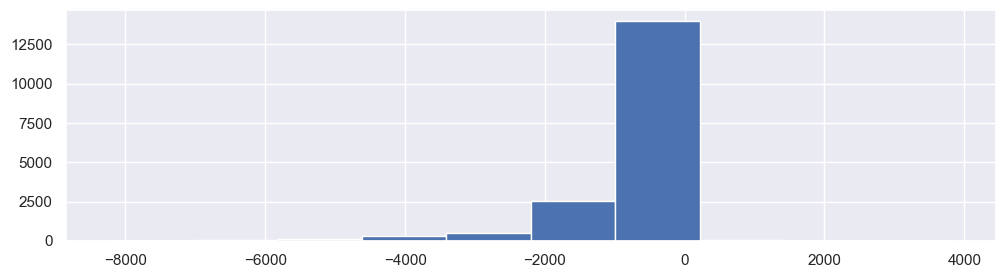

In [43]:
plt.hist(test.road_tax_diff)
plt.show()

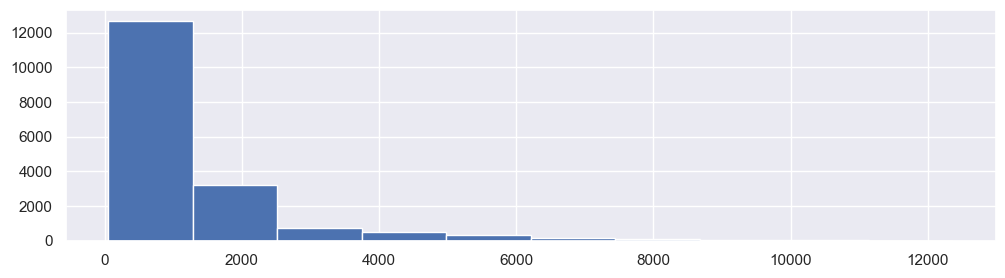

In [39]:
plt.hist(test.road_tax)
plt.show()

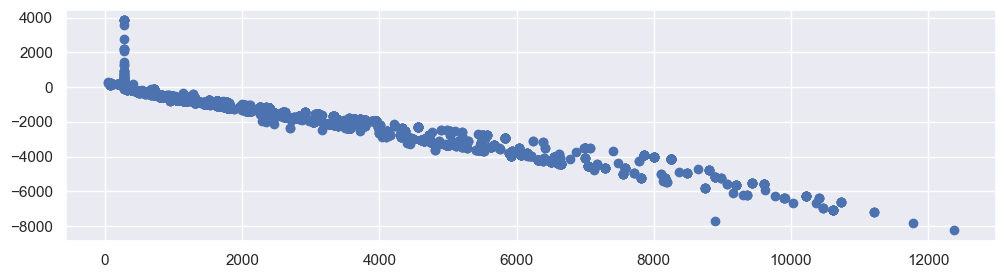

In [37]:
plt.scatter(x=test.road_tax, y=test.road_tax_diff)
plt.show()

### Cylinder Count

In [48]:
cylinder_count_extractor = CylinderExtractor()

train_df = cylinder_count_extractor.transform(train_df)
val_df = cylinder_count_extractor.transform(val_df) 
test_df = cylinder_count_extractor.transform(test_df) 

In [49]:
cylinder_imputer = CylinderImputer()
train_df = cylinder_imputer.fit_transform(train_df) # 1479 rows missing
val_df = cylinder_imputer.transform(val_df) # 334 rows missing
test_df = cylinder_imputer.transform(test_df)

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['cylinder_cnt'] = imputer.fit_transform(train_df[['cylinder_cnt']])
val_df['cylinder_cnt'] = imputer.transform(val_df[['cylinder_cnt']])
test_df['cylinder_cnt'] = imputer.transform(test_df[['cylinder_cnt']])

### Category Parser

In [61]:
category_parser = CategoryParser()
train_df = category_parser.fit_transform(train_df) 
val_df = category_parser.transform(val_df) 

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   listing_id                       20000 non-null  int64         
 1   title                            20000 non-null  object        
 2   make                             20000 non-null  object        
 3   model                            20000 non-null  object        
 4   description                      19459 non-null  object        
 5   manufactured                     19993 non-null  float64       
 6   original_reg_date                209 non-null    object        
 7   reg_date                         20000 non-null  object        
 8   type_of_vehicle                  20000 non-null  object        
 9   category                         20000 non-null  object        
 10  transmission                     20000 non-null  object   

### features 

In [32]:
train_df['cylinder_cnt'] = train_df['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
cylinder_count_dict = extract_cylinder_by_model_make(train_df)
train_df['cylinder_cnt'] = train_df.apply(lambda x:impute_row_by_make_model(x, cylinder_count_dict, 'cylinder_cnt'), axis=1)
# fill remaining values with median of 4 cylinder (most common engine)
median_cylinder_cnt = train_df['cylinder_cnt'].median(axis=0)
train_df['cylinder_cnt'] = train_df['cylinder_cnt'].fillna(median_cylinder_cnt)

In [33]:
train_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'reg_date', 'type_of_vehicle', 'category', 'curb_weight', 'power',
       'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe',
       'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme',
       'lifespan', 'eco_category', 'features', 'accessories',
       'indicative_price', 'price', 'reg_date_dt', 'reg_date_year',
       'reg_date_month', 'model_make', 'extracted_make', 'curb_weight_impute',
       'power_impute', 'engine_cap_impute', 'effective_reg_date', 'car_age',
       'transmission_auto', 'omv_new', 'cylinder_cnt'],
      dtype='object')

### Processing scraped items 

In [4]:
combined_data = list()

folder_path = "/Users/melloo21/Desktop/NUS Items/CS5228/Project/CS5228_project/dataset"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pkl"):
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            combined_data.extend(data)

# Now you can use the combined_data list for further processing
display(len(combined_data))

scraped_new_car_info = pd.DataFrame(combined_data)

9441

In [85]:
def extrac_float_val(df:pd.DataFrame,variable:str, regex_pattern):
    proc = sanity_check_df[sanity_check_df[variable] != "unknown"].dropna(subset=[variable])
    if variable == "Power":
        proc[variable] = proc[variable].apply(lambda x: float(re.search(regex_pattern, x).group()))
    else:
        # Remove commas from the 'engine_cap' column using regex
        proc[variable] = proc[variable].apply(lambda x: re.sub(regex_pattern, '', x))
        # Convert the 'engine_cap' column to numeric
        proc[variable] = pd.to_numeric(proc[variable])
    return proc

def calc_vehicle_age(X):
    """
    Calculate the age of a vehicle - Used for depreciation imputation
    """
    current_year = datetime.now().year
    X['car_age'] = current_year - X['manufactured']
    return X

def knn_impute(feature:list, df:pd.DataFrame, neighbours:int, imputed_feature:str):
    
    impute_df = df[features]
    # Initialize KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    # Perform imputation
    imputed_array = imputer.fit_transform(impute_df)
    # Create a DataFrame from the imputed array
    imputed_df = pd.DataFrame(imputed_array, columns=features)

    # Add the imputed 'arf' values back to the original DataFrame
    df[f'{imputed_feature}_impute'] = imputed_df[imputed_feature]

    return df, imputer

In [6]:
sanity_check_df = orig_df.merge(scraped_new_car_info, on ="listing_id")

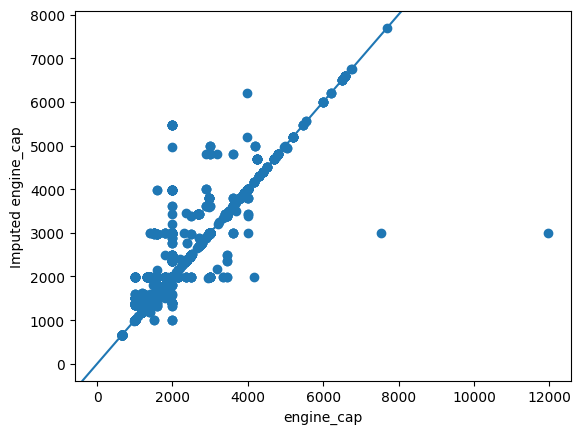

In [34]:
ref_variable = "engine_cap"
variable = "Engine Capacity"
# ENGINE REGEX 
engine_regex = r"\D"
test_df = extrac_float_val(df=sanity_check_df, variable=variable, regex_pattern=engine_regex)

plt.scatter(x=test_df[ref_variable],y=test_df[variable])
plt.xlabel(ref_variable)
plt.ylabel(f"Imputed {ref_variable}")
plt.axline((0, 0), slope=1)
plt.show()

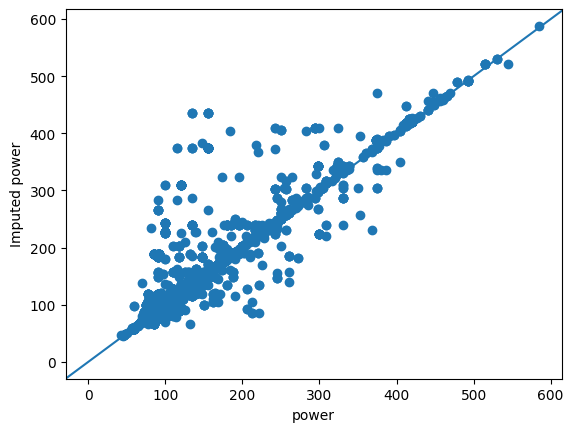

In [26]:
ref_variable = "power"
variable = "Power"
power_regex = r'\d+\.?\d*'
test_df = extrac_float_val(df=sanity_check_df, variable=variable, regex_pattern=power_regex)

plt.scatter(x=test_df[ref_variable],y=test_df[variable])
plt.xlabel(ref_variable)
plt.ylabel(f"Imputed {ref_variable}")
plt.axline((0, 0), slope=1)
plt.show()

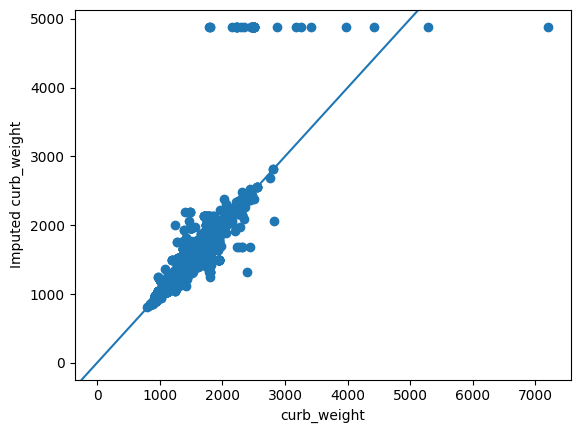

In [35]:
ref_variable = "curb_weight"
variable = "Kerb Weight"
# ENGINE REGEX 
curb_regex = r"\D"
test_df = extrac_float_val(df=sanity_check_df, variable=variable, regex_pattern=curb_regex)

plt.scatter(x=test_df[ref_variable],y=test_df[variable])
plt.xlabel(ref_variable)
plt.ylabel(f"Imputed {ref_variable}")
plt.axline((0, 0), slope=1)
plt.show()

In [13]:
## Using category
"""
# All categories ['-', 'almost new car', 'coe car', 'consignment car', 'direct owner sale', 'electric cars',
#  'hybrid cars','imported used vehicle', 'low mileage car', 'opc car', 'parf car','premium ad car', 
# 'rare & exotic', 'sgcarmart warranty cars', 'sta evaluated car', 'vintage cars']
"""
category_test = sanity_check_df.copy()
category_parser = CategoryParser()
category_test = category_parser.fit_transform(category_test)
display(category_test.columns)

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price', 'reg_date_dt',
       'reg_date_year', 'reg_date_month', 'Engine & Transmission',
       'Engine Capacity', 'Engine Type', 'Fuel Type', 'Drive Type',
       'Transmission', 'Performance', 'Power', 'Torque', 'Acceleration',
       'Top Speed', 'Fuel Consumption', 'CO2 Emission', 'Measurements',
       'Vehicle Type', 'Seating Capacity', 'Dimensions (L x W x H)',
       'Wheelbase', 'Min Turning Radius', 'Kerb Weight', 'Fuel Tank Capacity',
       'Boot/Cargo Capacity', 'Suspension (Front)', 'Suspension (Rear)',
       'Brakes (Front)', 'Brakes (Rear)', 'Rim Size

In [15]:
category_parser.categories_

array(['-', 'almost new car', 'coe car', 'consignment car',
       'direct owner sale', 'electric cars', 'hybrid cars',
       'imported used vehicle', 'low mileage car', 'opc car', 'parf car',
       'premium ad car', 'rare & exotic', 'sgcarmart warranty cars',
       'sta evaluated car', 'vintage cars'], dtype=object)

In [51]:
## Checking for fuel type
test_df = sanity_check_df[sanity_check_df["Fuel Type"] != "unknown"].dropna(subset=["Fuel Type", "fuel_type"])
test_df["Fuel Type"] = test_df["Fuel Type"].str.replace(r'Diesel \(Euro [IVX]+\)', 'Diesel', regex=True)
test_df["Fuel Type"] = test_df["Fuel Type"].str.lower()
test_df["fuel_type"] = test_df["fuel_type"].str.lower()
fuel_type_check = (test_df["Fuel Type"] == test_df["fuel_type"])
display(test_df[~fuel_type_check][["fuel_type", "Fuel Type"]])
fuel_type_check.value_counts()

,fuel_type,Fuel Type
390,diesel,petrol
2201,diesel,petrol
2351,petrol,diesel
2683,diesel,petrol
7234,petrol,diesel
8673,petrol,diesel


True     461
False      6
Name: count, dtype: int64

In [64]:
test_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price', 'reg_date_dt',
       'reg_date_year', 'reg_date_month', 'Engine & Transmission',
       'Engine Capacity', 'Engine Type', 'Fuel Type', 'Drive Type',
       'Transmission', 'Performance', 'Power', 'Torque', 'Acceleration',
       'Top Speed', 'Fuel Consumption', 'CO2 Emission', 'Measurements',
       'Vehicle Type', 'Seating Capacity', 'Dimensions (L x W x H)',
       'Wheelbase', 'Min Turning Radius', 'Kerb Weight', 'Fuel Tank Capacity',
       'Boot/Cargo Capacity', 'Suspension (Front)', 'Suspension (Rear)',
       'Brakes (Front)', 'Brakes (Rear)', 'Rim Size

In [87]:
test_df = sanity_check_df[sanity_check_df["Fuel Type"] != "unknown"]
test_df = calc_vehicle_age(test_df)
test_df["Fuel Type"] = test_df["Fuel Type"].str.replace(r'Diesel \(Euro [IVX]+\)', 'Diesel', regex=True)
test_df["Fuel Type"] = test_df["Fuel Type"].str.lower()

# test["road_tax_imputed"] = test.apply(lambda row: calculate_road_tax(row["engine_cap"],row["power"], row["car_age"], row["reg_date_dt"]))
for i, row in test_df.iterrows():
    test_df.loc[i,"road_tax_imputed"] = calculate_road_tax(
        engine_capacity=row["engine_cap"],power=row["power"], 
        age_of_car=row["car_age"], reg_date=row["reg_date_dt"],fuel_type=row["Fuel Type"])
test_df["road_tax_diff"] = test_df.road_tax_imputed - test_df.road_tax

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_3398/4006290554.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_3398/3807342516.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_3398/3807342516.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

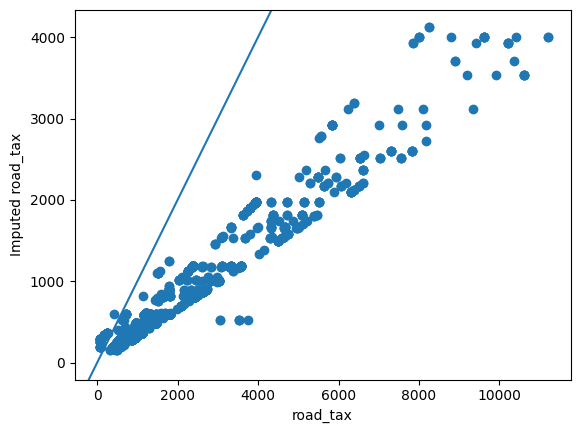

In [75]:
ref_variable = "road_tax"
variable = "road_tax_imputed"

plt.scatter(x=test_df[ref_variable],y=test_df[variable])
plt.xlabel(ref_variable)
plt.ylabel(f"Imputed {ref_variable}")
plt.axline((0, 0), slope=1)
plt.show()

In [88]:
## KNN Imputer for the road tax
features = ['manufactured',"power", "car_age","engine_cap",'reg_date_year', 'omv', 'arf', "road_tax",
'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
 'type_of_vehicle_mid-sized sedan','type_of_vehicle_mpv', 
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

test_df , vehicle_type_encoder = vehicle_type_fit_transform(test_df, "type_of_vehicle")
new_test_df , imputer = knn_impute(feature=features, df=test_df, neighbours=5, imputed_feature="road_tax")

'imputed_df (5498, 18)'

'df (5498, 87)'

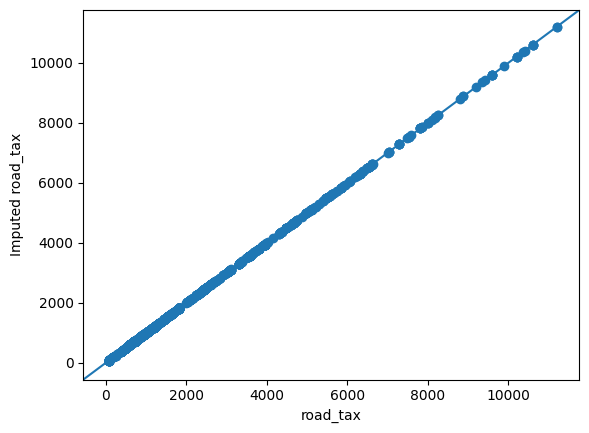

In [90]:
ref_variable = "road_tax"
variable = "road_tax_impute"

plt.scatter(x=test_df[ref_variable],y=test_df[variable])
plt.xlabel(ref_variable)
plt.ylabel(f"Imputed {ref_variable}")
plt.axline((0, 0), slope=1)
plt.show()

## Data normalization

In [34]:
display(HTML(train_df.head(5).to_html()))

,listing_id,title,make,model,description,manufactured,reg_date,type_of_vehicle,category,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_dt,reg_date_year,reg_date_month,model_make,extracted_make,curb_weight_impute,power_impute,engine_cap_impute,effective_reg_date,car_age,transmission_auto,omv_new,cylinder_cnt
0,1292132,Land Rover Range Rover Velar 3.0A Si6 R-Dynamic Sunroof,land rover,range,"1 owner, no repairs needed! it looks great, inside and out. it offers good comfort for four adults and decent cargo space. call us for viewing now to avoid disappointment!",2018.0,08-mar-2018,suv,parf car,1884.0,280.0,NaN,2995.0,2.0,34270.0,48011,2380.0,103323.0,96000.0,88906.0,132031.0,NaN,08-Mar-2028,uncategorized,"3l supercharged v6 p380 engine at 375bhp/450nm torque, 8 speed zf, bsm, lane departure warning/lane keep assist, adaptive cruise control, hud.","2 x massage/memory/cooling & warmer seat, rear electric seat, panoramic roof, meridian surround, virtual cockpit, carplay, 360 cam, auto/kick tailgate",NaN,193788.0,2018-03-08,2018,3,range_land rover,land rover,1884.0,280.0,2995.0,2018-03-08,6.0,True,88906.0,6.0
1,1294696,Mercedes-Benz C-Class C200 Sport Premium Sunroof,mercedes-benz,c200,"rare beautiful white c200 sport premium sunroof in the market. low mileage driven. most popular sedan in the market. in pristine condition. quiet and comfortable cabin to travel in top notch comfort, luxurious and superb efficient drive. smooth acceleration and powerful engine. easy and low cost maintenance. high loan financing available. high trade in offer. call now for a viewing appointment.",2017.0,28-dec-2017,luxury sedan,"parf car, premium ad car",1465.0,135.0,NaN,1991.0,2.0,21170.0,47002,1202.0,45179.0,85680.0,40678.0,43950.0,NaN,28-Dec-2027,uncategorized,"2.0l 4 cylinders inline turbocharged engine, paddle shifters, abs, esp, 8 x srs airbags, agility select, auto start/stop function, cruise control. view specs of the mercedes-benz c-class saloon","multi function steering, electric tailgate, reverse camera/sensors. keyless entry/start/stop, twin panoramic roofs with electric blinds.",NaN,96800.0,2017-12-28,2017,12,c200_mercedes-benz,mercedes-benz,1465.0,135.0,1991.0,2017-12-28,7.0,True,40678.0,4.0
2,1311717,Honda Odyssey 2.4A (COE till 09/2027),honda,odyssey,comes with warranty. full service done.,2007.0,19-sep-2007,mpv,"coe car, premium ad car, low mileage car",1648.0,118.0,NaN,2354.0,3.0,12520.0,50355,2442.0,16003.0,138000.0,27994.0,30794.0,NaN,19-Sep-2017,uncategorized,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 speed auto, abs, 2 airbags, cruise control, auto headlight, knockdown rear seats. view specs of the honda odyssey","cruise control, touchscreen audio, reverse camera and sensor, multi function steering controls.",NaN,39800.0,2007-09-19,2007,9,odyssey_honda,honda,1648.0,118.0,2354.0,2007-09-19,17.0,True,27994.0,4.0
3,1310068,Toyota Corolla Altis 1.6A (COE till 12/2028),toyota,altis,0,2008.0,15-dec-2008,mid-sized sedan,"coe car, premium ad car",1195.0,80.0,NaN,1598.0,3.0,10140.0,27571,1113.0,12184.0,160000.0,16084.0,16084.0,NaN,15-Dec-2018,uncategorized,"super fuel efficient 1.6l 16 valves dohc vvt-i engine, smooth auto transmission with ect, dual srs airbags, abs. view specs of the toyota corolla altis","leather seats, pioneer dvd audio system with reverse sensors/camera, retractable side mirrors with indicators.",NaN,44800.0,2008-12-15,2008,12,altis_toyota,toyota,1195.0,80.0,1598.0,2008-12-15,16.0,True,16084.0,4.0
4,1325280,Lexus GS300 (COE till 06/2026),lexus,gs,"wear and tear done up. well maintained and regularly serviced. no expenses were spared by the meticulous owner. accident free. unit in superb condition, view to believe! workshop check/sta evaluation can be arranged. viewing available in our showroom. bank / in house loan available. contact us today! viewing by appointment.",2006.

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from utils.models import Classification
from sklearn.impute import SimpleImputer


In [57]:

features = ['curb_weight_impute', 'power_impute', 'cylinder_cnt', 'omv_new',
       'engine_cap_impute', 'depreciation', 'mileage', 'dereg_value']

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['price'], test_size=0.3, random_state=42)


In [58]:
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[features])

X_train[features] = imputer.transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# Fit and transform the numerical columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [59]:
X_train[features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, 4913 to 23654
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   curb_weight_impute  17500 non-null  float64
 1   power_impute        17500 non-null  float64
 2   cylinder_cnt        17500 non-null  float64
 3   omv_new             17500 non-null  float64
 4   engine_cap_impute   17500 non-null  float64
 5   depreciation        17500 non-null  float64
 6   mileage             17500 non-null  float64
 7   dereg_value         17500 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


## Training models

In [66]:
train_df.isna().sum()

listing_id               0
title                    0
make                     0
model                    0
description            541
manufactured             7
original_reg_date    19791
reg_date                 0
type_of_vehicle          0
category                 0
transmission             0
curb_weight              0
power                    0
fuel_type            15339
engine_cap               0
no_of_owners             0
depreciation            96
coe                      0
road_tax              2098
dereg_value            185
mileage                  0
omv                      0
arf                    141
opc_scheme           19870
lifespan             18138
eco_category             0
features               672
accessories           3032
indicative_price     20000
price                    0
reg_date_dt              0
reg_date_year            0
reg_date_month           0
car_age                  7
cylinder_cnt             0
model_make               0
dtype: int64

In [24]:
# display(HTML(train_df.head(50).to_html()))
# 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
       'engine_cap', 'depreciation', 'mileage', 'no_of_owners','type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

# train_df[features].isna().sum()

In [84]:
# Scale dataset
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')

imputer.fit(train_df[features])

# Split data into training and test sets
train_df[features] = imputer.transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])
test_df[features] = imputer.transform(test_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

In [85]:
X_train = train_df[features]
y_train = train_df['price']

X_val = val_df[features]
y_val = val_df['price']

In [73]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': np.arange(50,350,50),
    'max_depth': np.arange(2,10,2),
    'min_samples_split': np.arange(10 ,60,10),
}


# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=5,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


Model Tuning Starttime :: 2024-10-30 17:34:55.278428


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model Tuning Completed :: 2024-10-30 18:03:49.817552
Best Parameters: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 150}


In [74]:
import joblib

# Save model 
model_name = "random_forest_v4"
save_path = f"./model_assets"
# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

['./model_assets/random_forest_v4.joblib']

In [75]:
import joblib
import plotly.express as px
import plotly.graph_objects as go

def _infer_type(data) -> np.ndarray:

    ## type checker

    try:
        assert type(data) == np.ndarray, "incorrect type"

    except AssertionError:
        data = data.to_numpy()
        print("INFO [_infer_type] :: Type changed")
        return data

    else:
        return data

def mini_reg_evaluate(
    df_train_tuple: tuple, df_valid_tuple: tuple, model_name: str, save_path:str
):

    model = joblib.load(f"{save_path}/{model_name}.joblib")
    X_train, y_train = df_train_tuple[0], df_train_tuple[1]
    X_valid, y_valid = df_valid_tuple[0], df_valid_tuple[1]

    ## type checker

    X_train = _infer_type(X_train)
    y_train = _infer_type(y_train)
    X_valid = _infer_type(X_valid)
    y_valid = _infer_type(y_valid)

    # Train and validation scores
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Visualize scatter plot for validation data
    plt.scatter(y_valid, y_valid_pred, color='blue', alpha=0.5)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--')
    plt.title("y_valid predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize scatter plot for training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
    plt.title("y_train predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize residual plot
    plt.scatter(y_valid_pred, y_valid_pred - y_valid, color='blue', alpha=0.5)
    plt.plot([y_valid_pred.min(), y_valid_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Validation Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5)
    plt.plot([y_train_pred.min(), y_train_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Training Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
  

In [7]:
model_name = "random_forest_v4"
save_path = f"./model_assets"

model = joblib.load(f"{save_path}/{model_name}.joblib")
# mini_reg_evaluate(df_train_tuple=(X_train, y_train),
# df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

feature_impt 25
 features 25


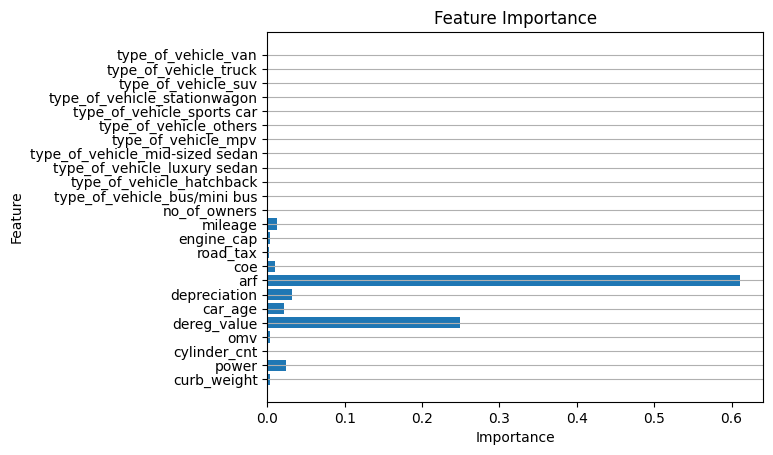

In [25]:
model_name = "random_forest_v4"
save_path = f"./model_assets"

reg_evaluate = RegressionEvaluate(model_weight_path= save_path)
reg_evaluate._plot_feature_immportance(model_name, features)

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



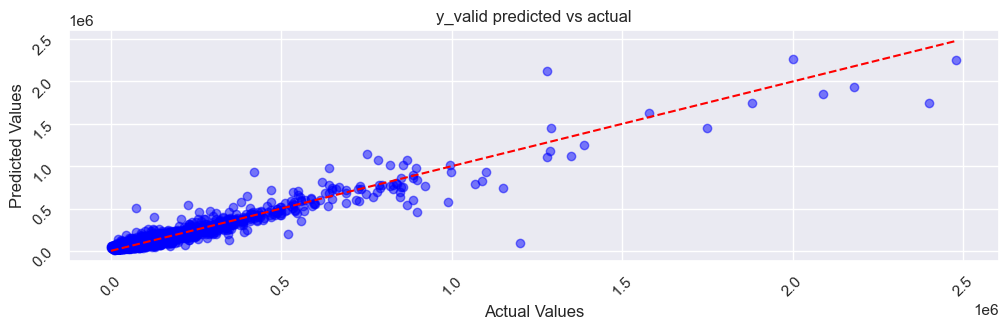

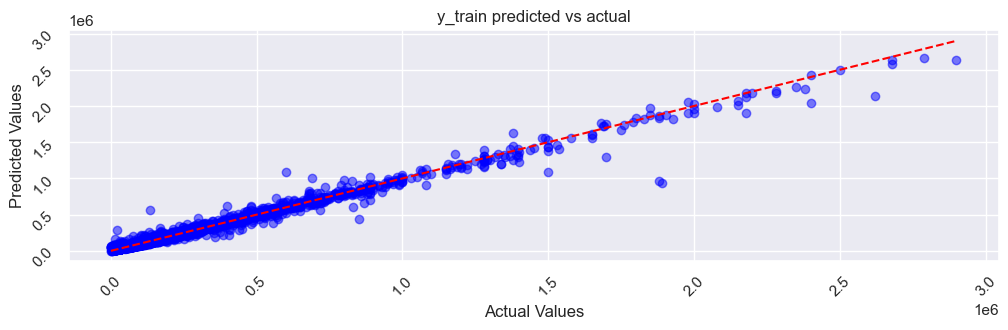

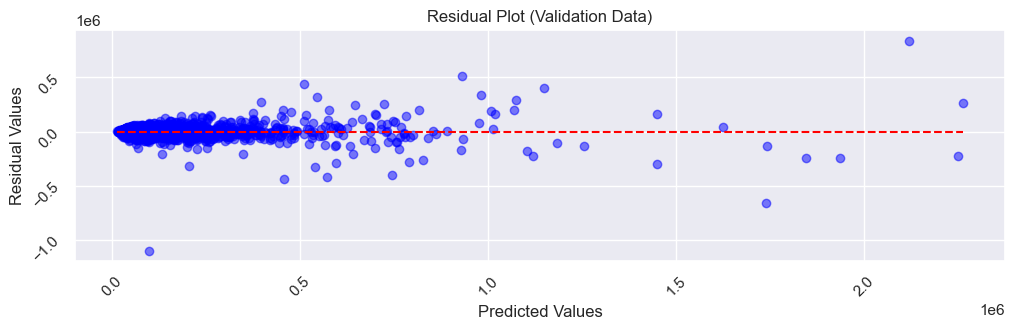

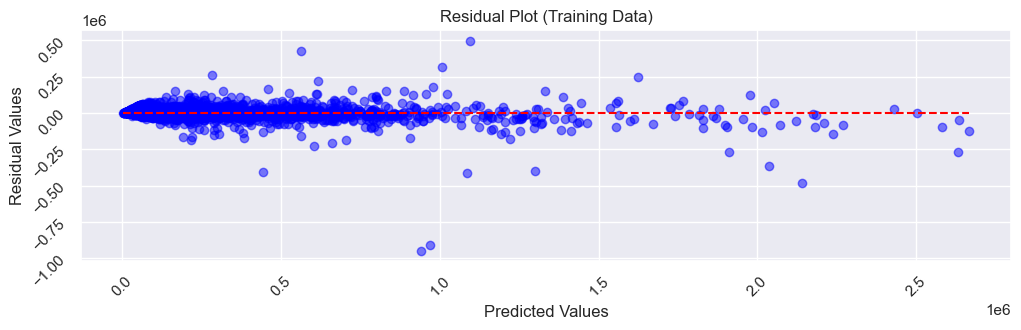

In [81]:
model_name = "random_forest_v3"
save_path = f"./model_assets"

mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

In [89]:
## Retrain the model
# Train + Valid (Retrain on the whole model)
# best params
# all data

all_x = pd.concat([train_df[features],val_df[features]])
all_y = pd.concat([train_df["price"],val_df["price"]])
final_model = tuner.fit(X_train, y_train)


In [92]:
final_model.best_estimator_

RandomForestRegressor(max_depth=8, min_samples_split=10, n_estimators=150)

In [93]:
model = joblib.load(f"{save_path}/{model_name}.joblib")
X_test = _infer_type(test_df[features])
y_test_pred = final_model.predict(X_test)
submission = pd.DataFrame(y_test_pred).reset_index().rename(columns={"index":"Id", 0:"Predicted"})
submission.to_csv(f"submission/submission_{model_name}_.csv")

INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

